In [1]:
import os
from os.path import join, exists, splitext, basename
from imp import reload
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch.nn import Parameter
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader

from pixyz.distributions import Normal, Bernoulli, Categorical
from pixyz.losses import KullbackLeibler, CrossEntropy
from pixyz.models import Model, VAE


from models import *
from utils import *

from mnist_A_data_loader import get_mnist_A_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

unique_label = []
for i in range(2):
    for j in range(3):
        for k in range(4):
            for l in range(10):
                unique_label.append([i, j, k, l])
unique_label = np.array(unique_label)

train_label_attr, test_label_attr = train_test_split(unique_label, random_state=42, test_size=40)
valid_label_attr, test_label_attr = train_test_split(test_label_attr, random_state=42, test_size=20)

train_loader = get_mnist_A_loader("../data/MNIST_A/train_X/",
                                  "../data/MNIST_A/train_y.npy", train_label_attr)
test_loader = get_mnist_A_loader("../data/MNIST_A/test_X/", 
                                 "../data/MNIST_A/test_y.npy", test_label_attr)
valid_loader = get_mnist_A_loader("../data/MNIST_A/valid_X/", 
                                  "../data/MNIST_A/valid_y.npy", valid_label_attr)

log_dir = "./logs"
classifier = MNIST_A_Classifier().to(device)
classifier.load_state_dict(torch.load(join(log_dir, 'MNIST_A_classifier.pkl')))
classifier.eval()

cuda


MNIST_A_Classifier(
  (conv_e): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc_e): Sequential(
    (0): Linear(in_features=8192, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=18, bias=True)
  )
)

In [3]:
z_dim = 64

loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim, name="p_prior")

p_x = Decoder_X().to(device)
p_y = Decoder_Y().to(device)

q = Encoder_XY().to(device)
q_x = Encoder_X().to(device)
q_y = Encoder_Y().to(device)

p = p_x * p_y
print(p)


kl = KullbackLeibler(q, prior)
kl_x = KullbackLeibler(q, q_x)
kl_y = KullbackLeibler(q, q_y)

regularizer = kl + kl_x + kl_y
print(regularizer)

model = VAE(q, p, other_distributions=[q_x, q_y],
            regularizer=regularizer, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

experiment_name =  'TELBO_MNIST_A_z_dim{}'.format(z_dim)

Distribution:
  p(x,y|z) = p(x|z)p(y|z)
Network architecture:
  p(y|z) (Bernoulli): Decoder_Y(
    (fc_d): Sequential(
      (0): Linear(in_features=64, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=1024, out_features=18, bias=True)
    )
  )
  p(x|z) (Bernoulli): Decoder_X(
    (fc_d): Sequential(
      (0): Linear(in_features=64, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=1024, out_features=8192, bias=True)
      (4): LeakyReLU(negative_slope=0.2)
    )
    (conv_d): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0

# train

999it [01:07, 14.77it/s]

train
↓generate


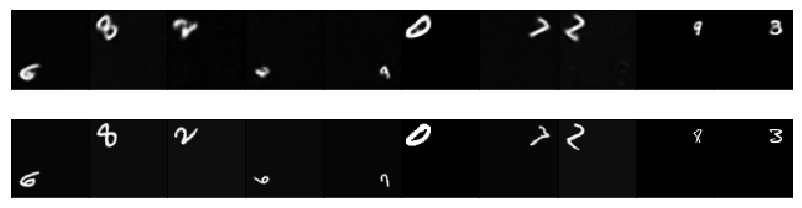

↑true
valid
↓generate


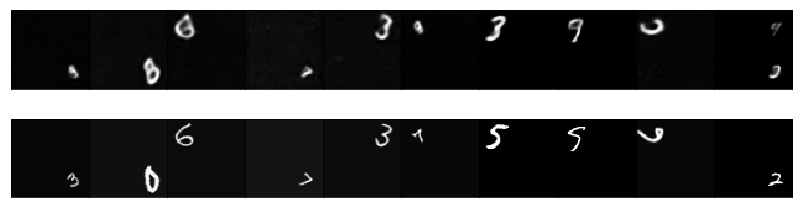

1001it [01:10, 14.26it/s]

↑true


1563it [01:49, 14.29it/s]
22it [00:01, 14.08it/s]

In [ ]:
#%debug
for i in range(3):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = y.to(device)
        loss = model.train({"x": x, "y": y})
 
        if (batch_idx+1)%1000==0:
            print("train")
            encoder_plot(train_loader, q_x, p_x, conditional=False)
            print("valid")
            encoder_plot(valid_loader, q_x, p_x, conditional=False)


In [ ]:
torch.save(p_x.state_dict(), join(log_dir, 'px_{}.pkl'.format(experiment_name)))
torch.save(p_y.state_dict(), join(log_dir, 'py_{}.pkl'.format(experiment_name)))
torch.save(q_x.state_dict(), join(log_dir, 'qx_{}.pkl'.format(experiment_name)))
torch.save(q_y.state_dict(), join(log_dir, 'qy_{}.pkl'.format(experiment_name)))
torch.save(q.state_dict(), join(log_dir, 'q_{}.pkl'.format(experiment_name)))

# 検証

- train dataにある属性なら生成できるのか
- test dataにある属性は生成できないのか

In [4]:
p_x.load_state_dict(torch.load(join(log_dir, 'px_{}.pkl'.format(experiment_name))))
p_y.load_state_dict(torch.load(join(log_dir, 'py_{}.pkl'.format(experiment_name))))
q_x.load_state_dict(torch.load(join(log_dir, 'qx_{}.pkl'.format(experiment_name))))
q_y.load_state_dict(torch.load(join(log_dir, 'qy_{}.pkl'.format(experiment_name))))
q.load_state_dict(torch.load(join(log_dir, 'q_{}.pkl'.format(experiment_name))))

## testデータ

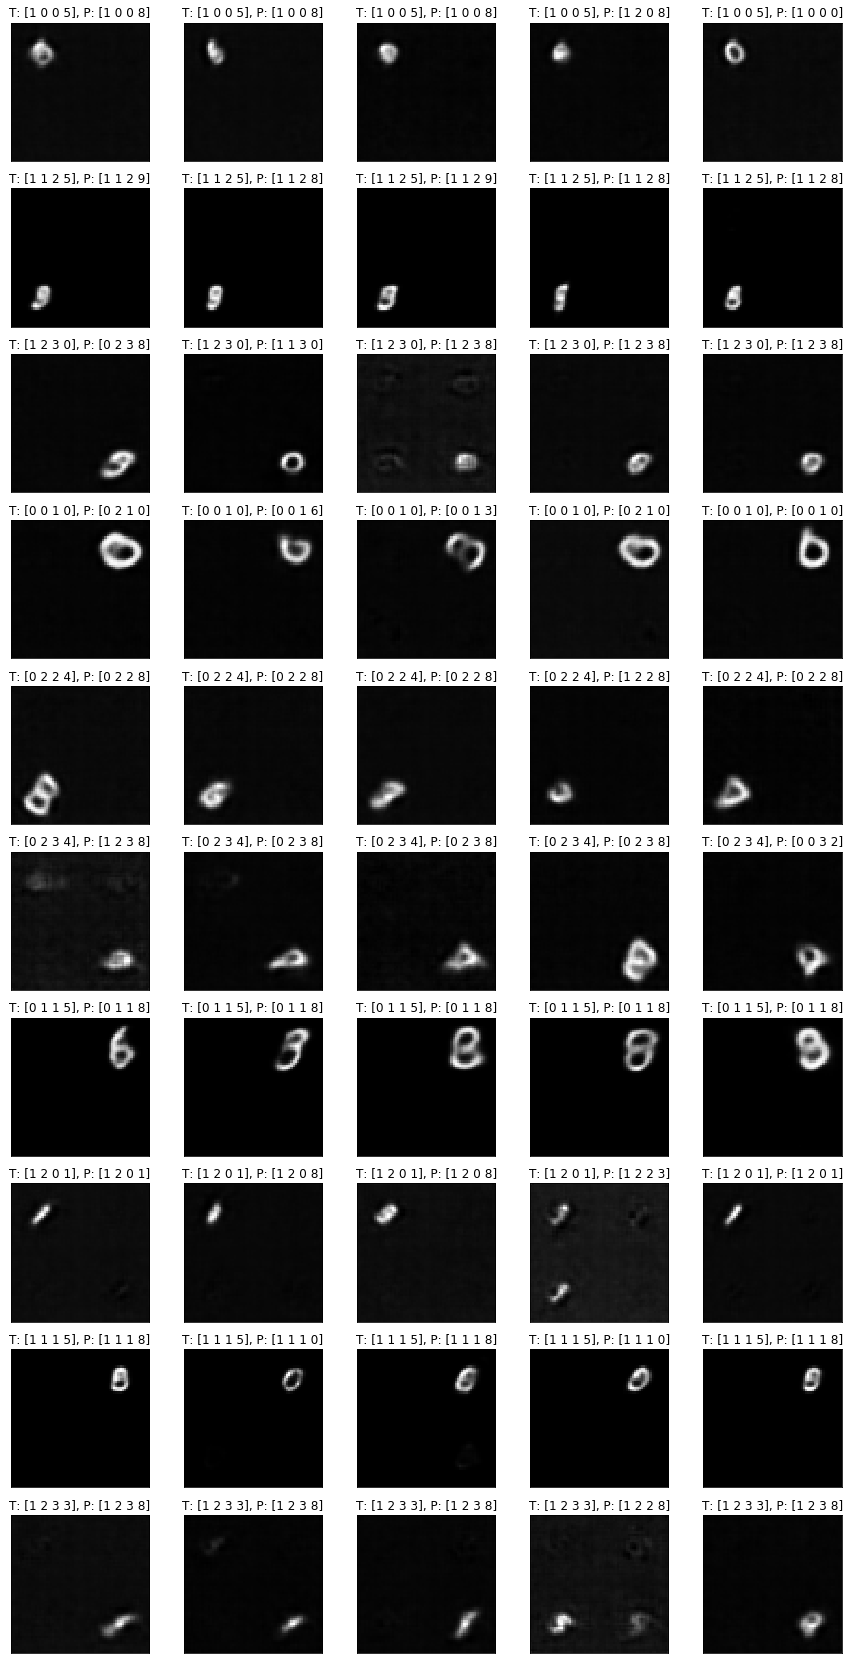

In [17]:
p_x.eval()
p_y.eval()
q_x.eval()
q_y.eval()
q.eval()

sample_size = 5
attr_size = 10
label = []
for j in range(attr_size):
        for i in range(sample_size):
            label.append(test_label_attr[j])
label = np.array(label)
onehot_label = torch.FloatTensor(label2onehot(np.array(label)))

z = q_y.sample({"y": onehot_label.to(device)})["z"]
samples = p_x.sample_mean({"z": z})
p_y1, p_y2, p_y3, p_y4 = classifier(samples)
pred = onehot2label(torch.cat([p_y1[:, None], p_y2, p_y3, p_y4], 1))
samples_ = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()
plt.figure(figsize=(sample_size*3, attr_size*3))
for i in range(sample_size*attr_size):
    plt.subplot(attr_size, sample_size, i+1)
    plt.xticks([])
    plt.yticks([])
    classifier(samples)
    plt.title("T: {}, P: {}".format(label[i], pred[i]))
    plt.imshow(samples_[i], plt.cm.gray)
plt.show()

In [15]:
# accuracy
accuracy_data = (pred == label).sum(1) == 4
accuracy_data.sum() / len(accuracy_data)

0.10000000000000001

## 訓練データ

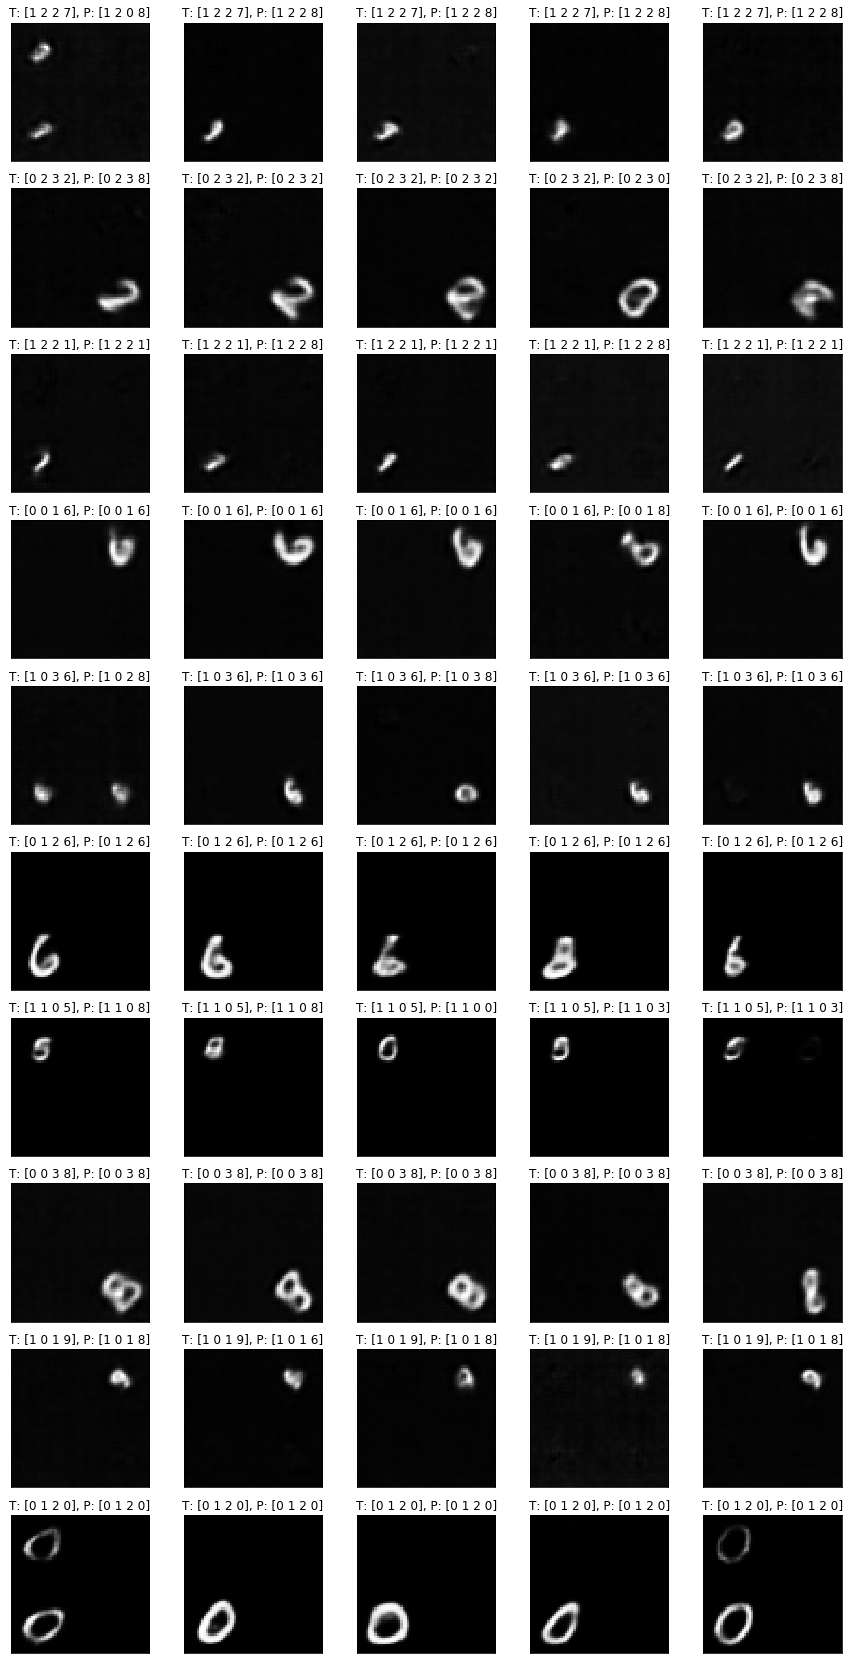

In [18]:
p_x.eval()
p_y.eval()
q_x.eval()
q_y.eval()
q.eval()

sample_size = 5
attr_size = 10
label = []
for j in range(attr_size):
        for i in range(sample_size):
            label.append(train_label_attr[j])
label = np.array(label)
onehot_label = torch.FloatTensor(label2onehot(np.array(label)))

z = torch.randn(sample_size*attr_size, z_dim).to(device)
z = q_y.sample({"y": onehot_label.to(device)})["z"]
samples = p_x.sample_mean({"z": z})
p_y1, p_y2, p_y3, p_y4 = classifier(samples)
pred = onehot2label(torch.cat([p_y1[:, None], p_y2, p_y3, p_y4], 1))
samples_ = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()
plt.figure(figsize=(sample_size*3, attr_size*3))
for i in range(sample_size*attr_size):
    plt.subplot(attr_size, sample_size, i+1)
    plt.xticks([])
    plt.yticks([])
    classifier(samples)
    plt.title("T: {}, P: {}".format(label[i], pred[i]))
    plt.imshow(samples_[i], plt.cm.gray)
plt.show()

In [19]:
# accuracy
accuracy_data = (pred == label).sum(1) == 4
accuracy_data.sum() / len(accuracy_data)

0.54000000000000004